In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

#utils


## GIPWE wrapper

### input: 

```xi``` (support of source measure) 

```w``` (weights of source measure) 

```xi_ring``` (support of target measure) 

```w_ring``` (weights of target measure)

```episilon``` (a prefixed small number to avoid division by 0 when conducting IPW)

```test_split_ratio``` (ratio of test data set when conducting classification)

```bootstrap_multiplier``` (times of the size of the bootstrapped samples when ```w``` and/or ```w_ring``` is/are not ```None```)

### output: 

```eta_ring``` (Riesz representer)


Based on the type of nuiance estimator of the intrumental supervised learning problem (shallow vs deep learning), there should be two wrappers, repectively based on ```numpy``` and ```pytorch```.

## Synthetic data

In [49]:
n = 500
m = 500
xi = torch.normal(mean = -1, std = 2, size = (n,1))
xi_ring = torch.zeros(size = (m,1))
for i in range(m):
    if torch.rand(1).item()>0.3:
        xi_ring[i,0] = torch.normal(mean = -4, std = 2, size = (1,)).item()
    else:
        xi_ring[i,0] = torch.normal(mean = 3, std = 0.2, size = (1,)).item()
        
print(type(xi) == torch.Tensor)
xi = xi.detach().numpy()
xi_ring = xi_ring.detach().numpy()
w = np.ones(n)
w_ring = np.ones(m)

True


In [50]:
def viz(weights, xi = xi,xi_ring = xi_ring):
    plt.figure(figsize = (12,8))
    plt.hist(xi_ring[:,0], alpha = 0.5, bins = 30, label ="target")
    plt.hist(xi[:,0], alpha = 0.5, bins = 30, label ="source")
    if weights is not None:
        plt.hist(xi[:,0], weights = weights, alpha = 0.5, bins = 30, label ="re-weighted source")
    plt.legend()

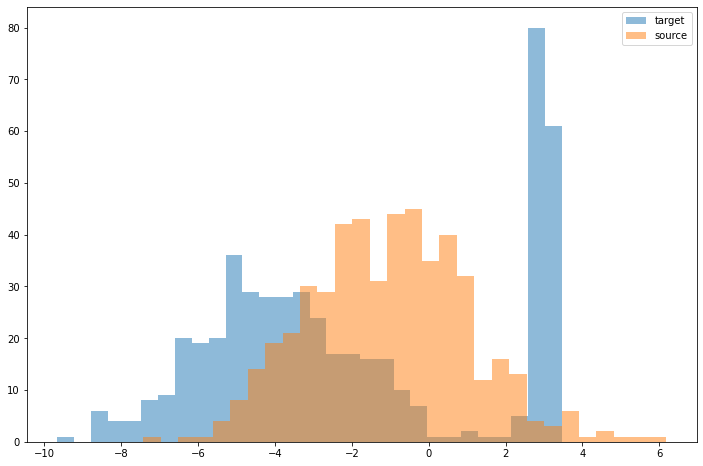

In [51]:
viz(None)

## Shallow GIPW wrapper

In [52]:
class Shallow_GIPW:
    def __init__(self, xi, xi_ring, w =None, w_ring = None, epsilon = 1e-8, test_split_ratio = 0.2, bootstrap_multiplier = 2):
        # parameter used to avoid division by 0
        self.epsilon = epsilon
        # import support of source and target measures
        self.xi = xi
        self.xi_ = xi # backup
        self.xi_ring = xi_ring
        
        self.n = self.xi.shape[0]
        self.m = self.xi_ring.shape[0]
        # backup
        self.n_ = self.xi.shape[0]
        self.m_ = self.xi_ring.shape[0]
        # init weights
        if w is not None:
            self.w_bootstrap_indicator = True
            self.w = w
        else:
            self.w = np.ones(self.n)
            self.w_bootstrap_indicator = False
        if w_ring is not None:
            self.w_ring_bootstrap_indicator = True
            self.w_ring = w_ring
        else:
            self.w_ring = np.ones(self.m)
            self.w_ring_bootstrap_indicator = False
        ## setup artificial supervised learning problem
        if self.w_bootstrap_indicator:
            self.xi = self.xi[np.random.choice(self.n, size = int(self.n*bootstrap_multiplier), p = self.w/np.sum(self.w))]
            self.n *= bootstrap_multiplier
        if self.w_ring_bootstrap_indicator:
            self.xi_ring = self.xi_ring[np.random.choice(self.m, size = int(self.m*bootstrap_multiplier), p = self.w_ring/np.sum(self.w_ring))]
            self.m *= bootstrap_multiplier
        X = np.concatenate((self.xi,self.xi_ring), axis = 0)
        Y = np.concatenate((np.zeros(self.n), np.ones(self.m)), axis = 0)
        # apply a random permutation
        random_indices = np.random.choice(self.n+self.m, self.n+self.m, replace = False)
        X = X[random_indices]
        Y = Y[random_indices]
        # train/test splitting
        self.Xtrain = X[random_indices[0:int((self.n+self.m)*test_split_ratio)],:]
        self.Ytrain = Y[random_indices[0:int((self.n+self.m)*test_split_ratio)]]
        self.Xtest = X[random_indices[int((self.n+self.m)*test_split_ratio)+1:],:]
        self.Ytest = Y[random_indices[int((self.n+self.m)*test_split_ratio)+1:]]
        
    def train(self,model, log = False):
        model.fit(self.Xtrain, self.Ytrain.reshape((self.Xtrain.shape[0],)))
        test_loss = np.mean((model.predict(self.Xtest) - self.Ytest)**2)
        train_loss = np.mean((model.predict(self.Xtrain) - self.Ytrain)**2)
        if log:
            print("train loss:", train_loss)
            print("test loss:", test_loss)
        try:
            e = model.predict_proba(self.xi_)[:,1] 
        except:
            e = model.predict(self.xi_) 
            
        self.weights = e/(1.-e+self.epsilon) *self.n_/self.m_
        
        
        
        
        
        
    
        
        
    
            

In [53]:
type(None)

NoneType

In [54]:
SGIPW = Shallow_GIPW(xi, xi_ring)

### Random Forests GIPW

In [55]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators = 100, min_samples_split = 50)

SGIPW = Shallow_GIPW(xi, xi_ring, w = np.ones(n), w_ring = np.ones(m), bootstrap_multiplier = 1)
SGIPW.train(RF,log=True)
weights = SGIPW.weights


train loss: 0.15776166422322954
test loss: 0.15973781783682886


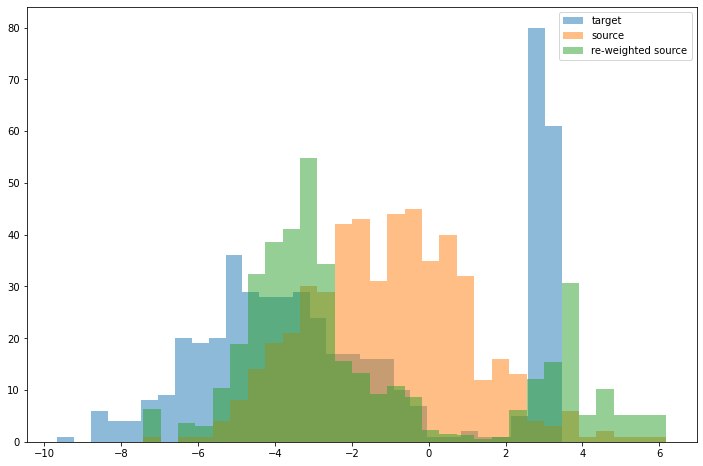

In [56]:
viz(weights)

### XGBoost GIPW

In [57]:
import xgboost as xgb
SGIPW = Shallow_GIPW(xi, xi_ring)
XGB = xgb.XGBRegressor(n_estimators = 10, gamma = 3)
SGIPW.train(XGB,log=True)
weights = SGIPW.weights

train loss: 0.16248012456551023
test loss: 0.18338981421927453


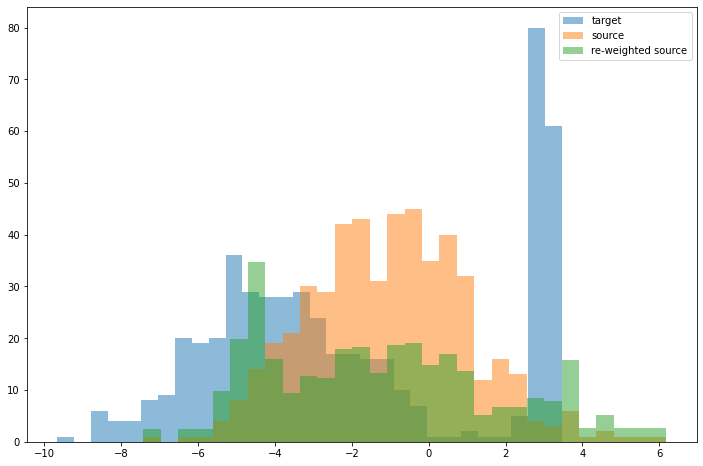

In [58]:
viz(weights)

### Logistic Regression GIPW

In [59]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty = "none")
SGIPW.train(LR,log=True)
weights = SGIPW.weights

train loss: 0.355
test loss: 0.3454317897371715


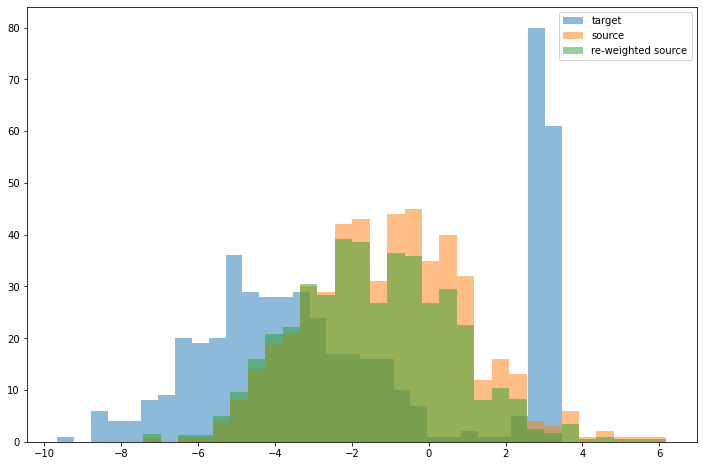

In [60]:
viz(weights)

## Deep GIPW

Now, we implement the idea of GIPW with a NN. Though the basic idea remains the same as described in the previous Shallow GIPW wrapper, the implementation of the Deep GIPW is quite different. We provide here a ```pytorch``` version of ```Deep_GIPW```.

In [61]:
# detect whether cuda is available
if torch.cuda.is_available():
    dev = "cpu" 
else:
    dev = "cuda:0"
    
xi = torch.from_numpy(xi).to(dev)
xi_ring = torch.from_numpy(xi_ring).to(dev)
w = torch.from_numpy(w).to(dev)
w_ring = torch.from_numpy(w_ring).to(dev)

In [62]:
class Deep_GIPW():
    def __init__(self, xi = xi, xi_ring = xi_ring, w = None, w_ring = None, epsilon = 1e-8, dev = dev, test_split_ratio = 0.2, bootstrap_multiplier = 2):
        self.epsilon = epsilon
        self.dev = dev
        with torch.no_grad():
            self.xi = xi.clone().to(self.dev)
            self.xi_ring = xi_ring.clone().to(self.dev)
            # backup
            self.xi_ = xi.clone().to(self.dev)
            self.xi_ring_ = xi_ring.clone().to(self.dev)
            if w is not None:
                self.w = w.clone().to(self.dev)
            else:
                self.w = torch.ones(len(xi)).clone().to(self.dev)
            if w_ring is not None:
                self.w_ring = w_ring.clone().to(self.dev)
            else:
                self.w_ring = torch.ones(len(xi_ring)).to(self.dev)
        self.n = len(xi)
        self.m = len(xi_ring)
        # backup
        self.n_ = len(xi)
        self.m_ = len(xi_ring)
        
        if w is not None:
            self.w_bootstrap_indicator = True
            self.w = w.to(self.dev)
        else:
            self.w = torch.ones(self.n).to(self.dev)
            self.w_bootstrap_indicator = False
        if w_ring is not None:
            self.w_ring_bootstrap_indicator = True
            self.w_ring = w_ring.to(self.dev)
        else:
            self.w_ring = torch.ones(self.m).to(self.dev)
            self.w_ring_bootstrap_indicator = False
        ## setup artificial supervised learning problem
        if self.w_bootstrap_indicator:
            self.xi = self.xi[np.random.choice(self.n, size = int(self.n*bootstrap_multiplier), p = self.w/torch.sum(self.w))]
            self.n *= bootstrap_multiplier
        if self.w_ring_bootstrap_indicator:
            self.xi_ring = self.xi_ring[np.random.choice(self.m, size = int(self.m*bootstrap_multiplier), p = self.w_ring/torch.sum(self.w_ring))]
            self.m *= bootstrap_multiplier
        X = torch.cat((self.xi,self.xi_ring), axis = 0)
        Y = torch.cat((torch.zeros((self.n,1)), torch.ones((self.m,1))), axis = 0)
        # apply a random permutation
        random_indices = np.random.choice(self.n+self.m, self.n+self.m, replace = False)
        X = X[random_indices]
        Y = Y[random_indices]
        # train/test splitting
        self.Xtrain = X[random_indices[0:int((self.n+self.m)*test_split_ratio)],:]
        self.Ytrain = Y[random_indices[0:int((self.n+self.m)*test_split_ratio)]]
        self.Xtest = X[random_indices[int((self.n+self.m)*test_split_ratio)+1:],:]
        self.Ytest = Y[random_indices[int((self.n+self.m)*test_split_ratio)+1:]]
    
    def train(self,
              model,
              optimizer,
              batch_size = 64,
              epochs = 500):
        loss_fn = nn.MSELoss()
        dataset_train = TensorDataset(self.Xtrain,self.Ytrain.type(torch.float))
        dataset_test = TensorDataset(self.Xtest,self.Ytest.type(torch.float))
        train_dataloader = DataLoader(dataset_train, batch_size=batch_size)
        test_dataloader = DataLoader(dataset_test, batch_size=batch_size)
        def train_loop():
            size = len(train_dataloader.dataset)
            for batch, (X, y) in enumerate(train_dataloader):
                # Compute prediction and loss
                pred = model(X)
                loss = loss_fn(pred, y)
        
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                if batch % 100 == 0:
                    loss, current = loss.item(), batch * len(X)
                    #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            return loss


        def test_loop():
            size = len(test_dataloader.dataset)
            num_batches = len(test_dataloader)
            #test_loss, correct = 0, 0
            test_loss = 0
        
            with torch.no_grad():
                for X, y in test_dataloader:
                    pred = model(X)
                    test_loss += loss_fn(pred, y).item()
                    #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
            test_loss /= num_batches
            return test_loss
        test_loss_trace = []
        train_loss_trace = []
        for t in tqdm(range(epochs)):
            current_train_loss = train_loop()
            current_test_loss = test_loop()
            test_loss_trace.append(current_test_loss)
            train_loss_trace.append(current_train_loss.to("cpu").detach().numpy())
        return train_loss_trace, test_loss_trace
        
        
        

In [63]:
DGIPW = Deep_GIPW(xi,xi_ring,w,w_ring)

### build NN for supervised learning

In [64]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_dim = 1, num_nodes = 16):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_dim, num_nodes),
            nn.ReLU(),
            #nn.Dropout(0.3),
            #nn.BatchNorm1d(num_nodes), 
            
            nn.Linear(num_nodes, num_nodes),
            nn.Sigmoid(),
            nn.Linear(num_nodes, num_nodes),
            nn.Sigmoid(),
            #nn.Dropout(0.3),
            #nn.BatchNorm1d(num_nodes), 
            
            #nn.Linear(num_nodes, num_nodes),
            #nn.ReLU(),
            # # #nn.Dropout(0.3),
            # # nn.BatchNorm1d(num_nodes), 
            
            nn.Linear(num_nodes, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.flatten(x)
        target = self.linear_stack(x)
        return target

### build Adam optimizer

In [70]:
learning_rate = 1e-3
model = NeuralNetwork(num_nodes = 16).to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)

In [71]:
train_loss_trace, test_loss_trace = DGIPW.train(model, optimizer)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 29.60it/s]


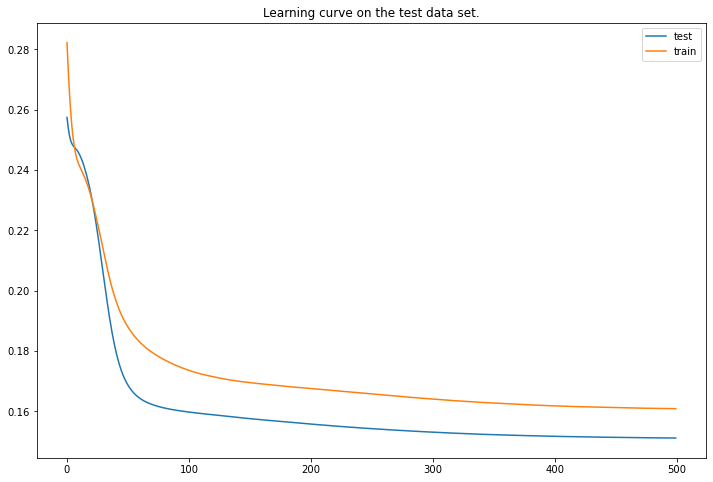

In [72]:
plt.figure(figsize = (12,8))
plt.plot(np.array(test_loss_trace), label ="test")
plt.plot(np.array(train_loss_trace), label = "train")
plt.title("Learning curve on the test data set.")
plt.legend()

In [73]:
e = model(DGIPW.xi_)
weights = e/(1.-e+DGIPW.epsilon) *DGIPW.n_/DGIPW.m_
weights = weights.to("cpu").detach().numpy()

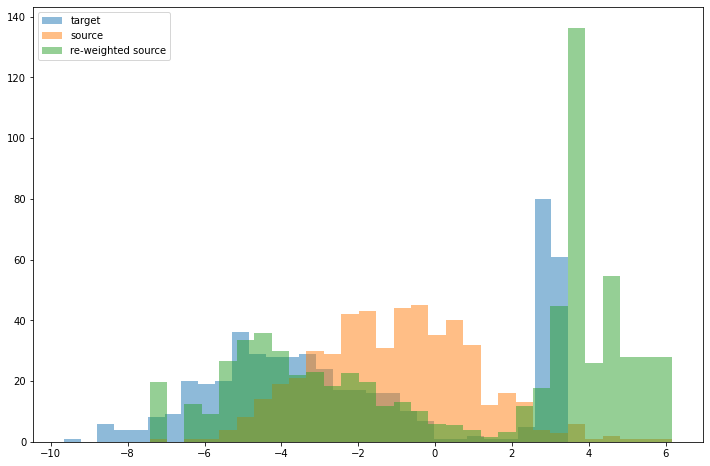

In [74]:
viz(weights)